<!--HEADER-->
*Notas de aula de Modelagem Matemática - 2021/1 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2021p1/notas_de_aula/08.01-Modelo_diodo.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/julia-env-for-binder-2021p1?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252Fmodelagem_matematica%26branch%3Dmodmat2021p1%26urlpath%3Dtree%252Fmodelagem_matematica%252Fnotas_de_aula/08.01-Modelo_diodo.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/modelagem_matematica/blob/modmat2021p1/notas_de_aula/slides/08.01-Modelo_diodo.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 8. Eletrônica](08.00-Eletronica.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [9. Reações químicas e bioquímicas ->](09.00-Reacoes_quimicas.ipynb)

---


# Modelagem da relação voltagem-corrente de um diodo

* Vamos exemplificar o processo modelagem com a relação entre a voltagem aplicada e a corrente através de um diodo.

In [1]:
using Random
using Statistics
using LsqFit
using LinearAlgebra
using Distributions: MvNormal, Normal
using Plots

## Diodos

* Um [diodo](https://en.wikipedia.org/wiki/Diode) é um componente eletrônico cuja propriedade principal é a de conduzir corrente essencialmente em apenas uma direção.

* Possui baixa resistência à corrente em um sentido, facilitando esse sentido de condução, e alta resitência no outro sentido.

* É usado para proteger um circuito; para converter um sinal de corrente alternada em corrente contínua; para extrair informações moduladas de sinais de rádio; etc.

* Há vários tipos de diodos, sendo um deles o das conhecidas "luzes" de LEDs.

## Dados de voltagem e corrente

* Vamos usar duas amostras de dados.

* A primeira que vamos considerar foi extraída de um circuito em um Raspberry Pi e reportada por um membro do servidor Discord [Humans of Julia](https://disboard.org/server/762167454973296644).

* Os dados de voltagem estão em [Volts (V)](https://michaelis.uol.com.br/busca?r=0&f=0&t=0&palavra=volt) e os de corrente em [miliamperes (mA)](https://michaelis.uol.com.br/busca?id=G9bqx).

In [2]:
V_data = [0.0, 0.2, 0.3, 0.47, 0.52, 0.56, 0.58, 0.62, 0.65, 0.66, 0.69, 0.7, 0.72]
I_data = [0.0, 0.0, 0.0, 0.1, 0.25, 0.55, 1.0, 2.0, 4.0, 6.0, 10.0, 15.0, 19.5]
nothing

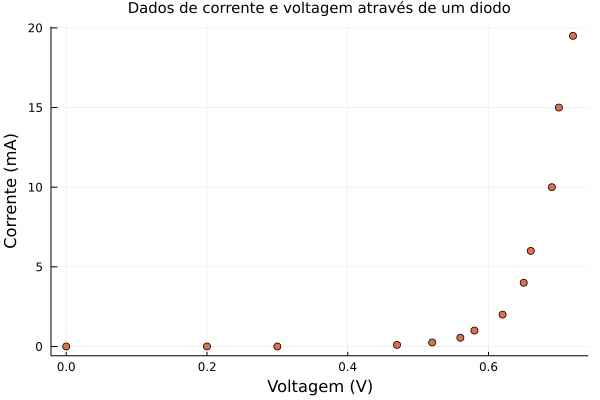

In [3]:
scatter(V_data, I_data, legend=false, color=2,
    title="Dados de corrente e voltagem através de um diodo", titlefont=10,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)")

## Modelo

### Analisando a taxa de crescimento da corrente

* Observe que o crescimento é bem rápido. Pode ser polinomial ou exponential ou até mesmo ter uma singularidade.

* Podemos investigar melhor o que acontece usando escala logarítmica na ordenada.

* Esse procedimento parece indicar um crescimento exponencial da corrente, em relação à voltagem.

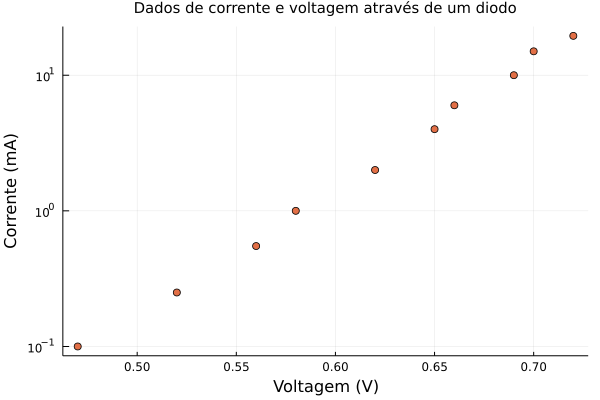

In [4]:
scatter(V_data[4:end],I_data[4:end], legend=false, yscale=:log10, color=2,
    title="Dados de corrente e voltagem através de um diodo", titlefont=10,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)")

### Translação

* E observe, naturalmente, que a corrente é nula quando a voltagem é nula.

* A corrente continua sendo nula quando a voltagem é relativamente muito baixa, provavelmente devida à resistência do próprio fio/condutor. Mas isso não será levado em consideração em um modelo "ideal".

* De qualquer forma, um modelo puramente exponencial $V \mapsto \beta_0 e^{\beta_1 V}$ não tem como se anular na origem (nem em qualquer ponto).

* Para isso, podemos considerar uma *translação:*
$$ I = \beta_0 (e^{\beta_1 V} - 1)
$$

### Modelo de dois parâmetros

* Chegamos, assim, ao seguinte modelo de dois parâmetros.

In [5]:
model(V,β) = β[1] * (exp.(β[2] * V) .- 1)

model (generic function with 1 method)

### O modelo de Shockley

* O modelo acima tem exatamente a forma (em relação a $V$) da [equação de Shockley de um diodo ideal](https://en.wikipedia.org/wiki/Shockley_diode_equation):
$$ {\displaystyle I=I_{\mathrm{S}}\left(e^{\displaystyle \frac{qV}{nkT}}-1\right)}
$$

* Parâmetros:
  * $I_{\mathrm{S}}$ é uma corrente de saturação;
  * $V_T=nkT/q$ é a voltagem térmica; onde
  * $k$ é a constante de Boltzmann;
  * $T$ é a temperatura; 
  * $q$ é a carga elétrica de um elétron; e
  * $n$ é um fator de idealidade, qualidade, ou, ainda, coeficiente de emissão.

## Ajuste do modelo

* Façamos, agora, o ajuste do modelo, usando o pacote [JuliaNLSolvers/LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl), de mínimos quadrados não-linear.

In [6]:
function info_ajuste2(dados_x, dados_y, model_y, m)
    N = length(dados_x)
    y_mean = mean(dados_y)
    residuos = model_y - dados_y
    ss = norm(residuos)^2
    rms = sqrt(ss/N)
    ss_y = norm(dados_y)^ 2
    rms_y = sqrt(ss_y/N)

    ss_rel = ss/ss_y
    rms_rel = sqrt(ss_rel)
    ss_tot = N*var(dados_y)
    ss_reg = norm(model_y .- y_mean)^2
    r_sq = ss_reg/ss_tot
    r_sq_aj = 1 - (1 - r_sq)*(N-1)/(N-m)
    
    aic = N*log(ss/N) + 2*m
    aicc = N*log(ss/N) + (2*m*(m+1))/(N-m-1)
    bic =  N*log(ss/N) + 2*log(N)*m
    
    return (
        residuos=residuos, rms=rms, rms_rel=rms_rel, ss=ss, ss_rel=ss_rel,
        r_sq=r_sq, r_sq_aj=r_sq_aj, aic=aic, aicc=aicc, bic=bic
    )
end

info_ajuste2 (generic function with 1 method)

### Chute inicial

* Nos métodos para o problema de mínimos quadrados não linear, precisamos de um "chute inicial" nos parâmetros.

* Podemos observar o gráfico acima para esse chute.

* Para isso, consideramos a aproximação 
$$ \ln I = \ln \beta[1] + \ln(\exp(\beta[2] * V) - 1 ) \approx \ln\beta[1] + \ln(\beta[2] V) \approx \ln\beta[1] + \beta[2] V.
$$

* No gráfico, $I$ varia, aproximadamente, de $0.1$ a $10$, enquanto que $V$ vai de, aproximadamente, $0.47$ a $0.72$.

* Em termos de logaritmo natural, $\ln I$ varia de $\ln(0.1)$ a $\ln 10$

* Ou seja, $\beta[2] \approx (\ln(10)-\ln(0.1))/(0.72-0.47) \approx 4.6/0.25 \approx 18.4$

* E escolhendo o décimo-primeiro dado, temos 
$$ I\_\textrm{data}[11] \approx \textrm{model}(V\_\textrm{data}[11], \beta) = \beta[1] * (\exp(18.4 * V\_\textrm{data}[11]) - 1)
$$

* Ou seja,
$$ \beta[1] \approx \frac{10.0}{\exp(18.4 * 0.69) - 1)} \approx 3 \times 10^{-5}.
$$

* Assim, escolhemos $\boldsymbol{\beta} = (\beta_0, \beta_1) = (3 \times 10^{-5}, 18.4)$ como o "chute inicial" para o método de mínimos quadrados não-linear.

### A aproximação com o chute inicial

* Só de curiosidade, vamos comparar com a modelagem com o "chute inicial".

In [7]:
β₀ = [3e-5, 18.4]
info0 = info_ajuste2(
            V_data, I_data, 
            model.(V_data, Ref(β₀)), length(β₀)
    )

(residuos = [0.0, 0.0011593918221771775, 0.007459051115690811, 0.07093213558909225, 0.1789636438766955, 0.3455236252015743, 0.2939035258466902, 0.7011448924068566, 0.6911625430045394, -0.36114233411716157, -0.20684413728860562, -3.228465634497889, -2.491978940235665], rms = 1.1772964363886456, rms_rel = 0.15370995187368747, ss = 18.018349688734258, ss_rel = 0.02362674930501132, r_sq = 0.6662962289273413, r_sq_aj = 0.6359595224661905, aic = 8.243737008206054, aicc = 5.443737008206055, bic = 14.503534438052203)

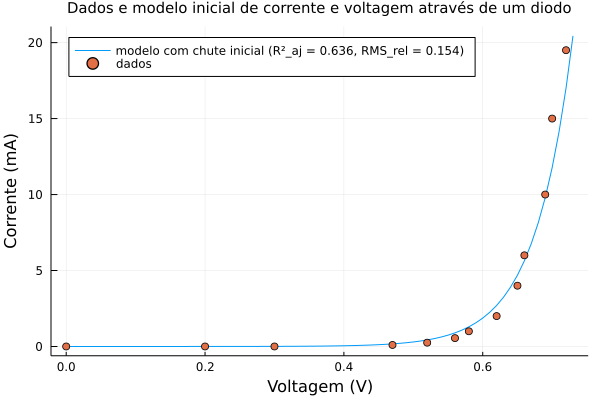

In [8]:
v = 0.0:0.01:0.73
plot(v, v -> model(v, β₀), 
    label="modelo com chute inicial (R²_aj = $(round(info0.r_sq_aj, digits=3)), RMS_rel = $(round(info0.rms_rel, digits=3)))")
scatter!(V_data, I_data, color=2, label="dados", legend=:topleft,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados e modelo inicial de corrente e voltagem através de um diodo", titlefont=10)

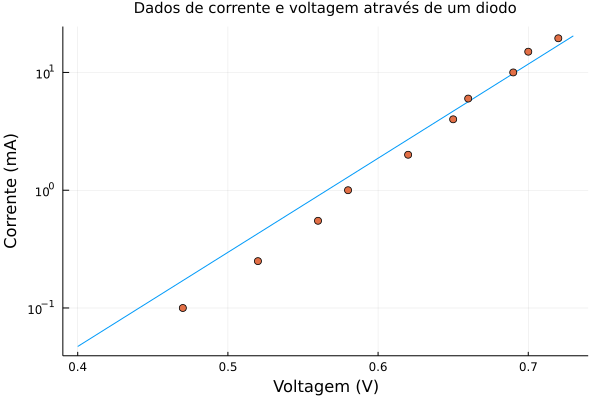

In [9]:
v = 0.4:0.01:0.73
plot(v, v -> model(v, β₀), yscale=:log10)
scatter!(V_data[4:end],I_data[4:end], legend=false, yscale=:log10, color=2,
    title="Dados de corrente e voltagem através de um diodo", titlefont=10,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)")

### Ajuste

In [10]:
β₀ = [3e-5, 18.4]
fit = curve_fit(model, V_data, I_data, β₀)
β_fit = fit.param

2-element Vector{Float64}:
  5.2698233226273774e-6
 21.051524579770025

In [11]:
info = info_ajuste2(
            V_data, I_data, 
            model.(V_data, Ref(β_fit)), length(β_fit)
    )

(residuos = [0.0, 0.00034979548967465366, 0.002909232080774908, 0.004418581507961747, 0.04917142139135816, 0.14442747830850833, 0.05798436366772752, 0.45574302292377666, 0.6180665167461106, -0.2998552055634436, 0.7192130917310209, -1.7691253579675177, 0.6576468950066712], rms = 0.606747947279064, rms_rel = 0.07921810929947963, ss = 4.785859929855652, ss_rel = 0.0062755088409843, r_sq = 0.903620736789333, r_sq_aj = 0.8948589855883633, aic = -8.99068725558163, aicc = -11.79068725558163, bic = -2.730889825735483)

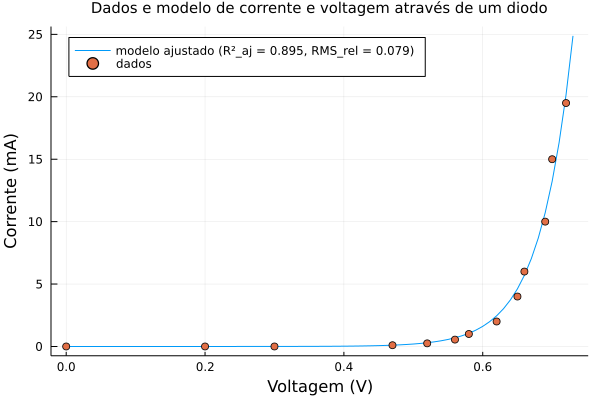

In [12]:
v = 0.0:0.01:0.73
plot(v, v -> model(v, β_fit), 
    label="modelo ajustado (R²_aj = $(round(info.r_sq_aj, digits=3)), RMS_rel = $(round(info.rms_rel, digits=3)))")
scatter!(V_data, I_data, color=2, label="dados", legend=:topleft,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados e modelo de corrente e voltagem através de um diodo", titlefont=10)

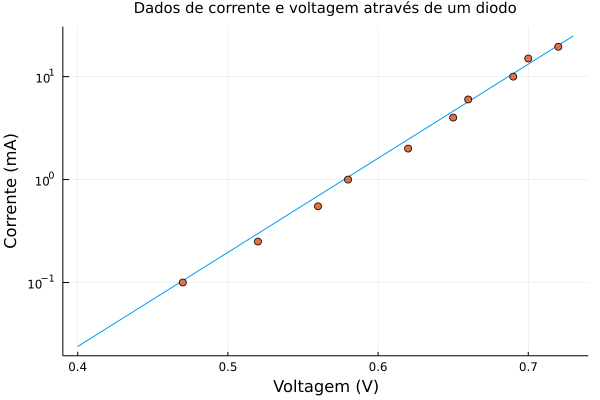

In [13]:
v = 0.4:0.01:0.73
plot(v, v -> model(v, β_fit), yscale=:log10)
scatter!(V_data[4:end],I_data[4:end], legend=false, yscale=:log10, color=2,
    title="Dados de corrente e voltagem através de um diodo", titlefont=10,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)")

## Um modelo com três parâmetros

* No artigo [E. Cataldo, A. Di Lieto F. Maccarrone, G. Paffuti, Measurements and analysis of current-voltage characteristic of a pn diode for an undergraduate physics laboratory](https://arxiv.org/abs/1608.05638v1), um modelo de três parâmetros é considerado, buscando capturar pequenos desvios em relação ao comportamente exponencial.

* O modelo aparece na equação (5), cujos parâmetros são $G$, $I_\mathrm{S}$ e $B$:
$$ I = GV + I_{\mathrm{S}}\left(e^{BV} - 1\right).
$$

In [14]:
model2(V,β) = β[1] * (exp.(β[2] * V) .- 1) .+ β[3] * V

model2 (generic function with 1 method)

### Chute inicial

* Para $\beta[1]$ e $\beta[2]$, usamos o mesmo chute inicial que antes (outra opção é usar os parâmetros obtidos com o ajuste acima).

* Em relação a $\beta[3]$, como esperamos que a sua contribuição seja pequena, vamos simplesmente chutá-lo como sendo nulo.

### Ajuste

In [15]:
β₀ = [3e-5, 18.4, 0.0]
fit2 = curve_fit(model2, V_data, I_data, β₀)
β_fit2 = fit2.param

3-element Vector{Float64}:
  9.116663604568188e-6
 20.30792538957126
 -0.45014624155005206

In [16]:
info2 = info_ajuste2(
            V_data, I_data, 
            model2.(V_data, Ref(β_fit2)), length(β_fit2)
    )

(residuos = [0.0, -0.08950899425262655, -0.13101911901052674, -0.18421073867720947, -0.13249371936954185, -0.009912434068327758, -0.07200183967772733, 0.4000703283181579, 0.6344675936117223, -0.2606072678543683, 0.7906860532773159, -1.714141413279421, 0.5914919663100804], rms = 0.5965153993472737, rms_rel = 0.07788212933595796, ss = 4.6257980815596875, ss_rel = 0.006065626069902885, r_sq = 0.9174789330651698, r_sq_aj = 0.9009747196782038, aic = -7.43290576171089, aicc = -10.766239095044224, bic = 1.9567903830583315)

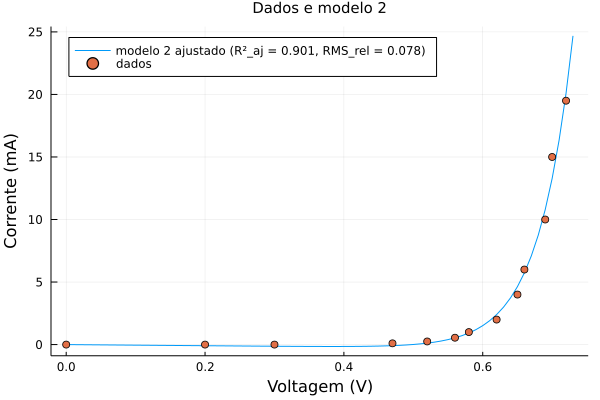

In [17]:
v = 0.0:0.01:0.73
plot(v, v -> model2(v, β_fit2), 
    label="modelo 2 ajustado (R²_aj = $(round(info2.r_sq_aj, digits=3)), RMS_rel = $(round(info2.rms_rel, digits=3)))")
scatter!(V_data, I_data, color=2, label="dados", legend=:topleft,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados e modelo 2", titlefont=10)

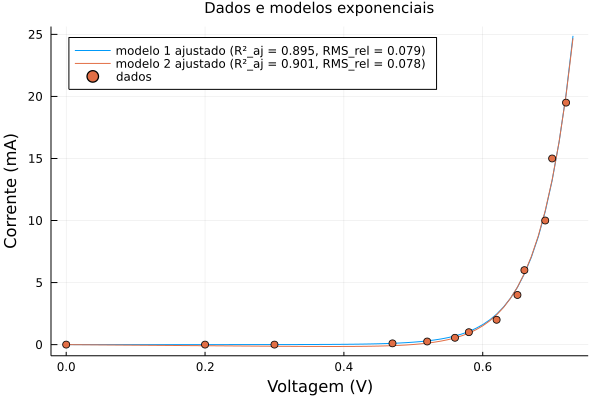

In [18]:
v = 0.0:0.01:0.73
plot(v, v -> model(v, β_fit), 
    label="modelo 1 ajustado (R²_aj = $(round(info.r_sq_aj, digits=3)), RMS_rel = $(round(info.rms_rel, digits=3)))")
plot!(v, v -> model2(v, β_fit2), 
    label="modelo 2 ajustado (R²_aj = $(round(info2.r_sq_aj, digits=3)), RMS_rel = $(round(info2.rms_rel, digits=3)))")
scatter!(V_data, I_data, color=2, label="dados", legend=:topleft,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados e modelos exponenciais", titlefont=10)

## Modelo polinomial

* Vamos, ainda, buscar modelos polinomiais, apenas para ilustração.

* Como estes são modelos lineares nos parâmetros, usamos o método de mínimos quadrados linear.

* Nesse caso, não precisamos de "chutes iniciais".

In [19]:
model_pol(V,β,grau) = β ⋅ [V^j for j = 0:grau]

model_pol (generic function with 1 method)

In [20]:
A(grau) = hcat([V_data.^j for j=0:grau]...);

β_pol = Dict()
info_pol = Dict()

grau_range = (3, 4, 6, 8, 12)
for grau in grau_range
    β_pol[grau] = A(grau) \ I_data
    info_pol[grau] = info_ajuste2(
            V_data, I_data, 
            model_pol.(V_data, Ref(β_pol[grau]), grau), length(β_pol[grau])
    )
end

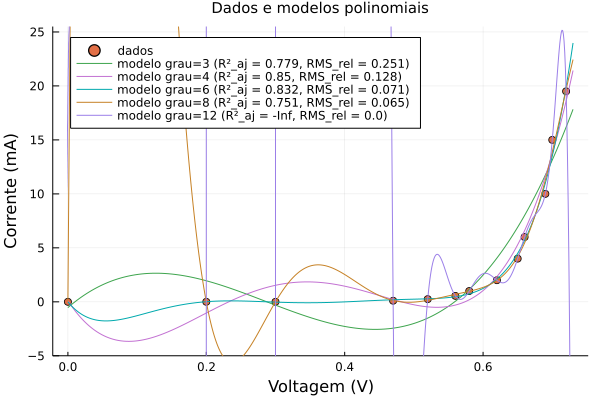

In [21]:
v = 0.0:0.001:0.73
scatter(V_data, I_data, color=2, label="dados", legend=:topleft, ylim=(-5,25.5))
for grau in grau_range
    plot!(v, v -> model_pol(v, β_pol[grau], grau), color = grau,
        label="modelo grau=$grau (R²_aj = $(round(info_pol[grau].r_sq_aj, digits=3)), RMS_rel = $(round(info_pol[grau].rms_rel, digits=3)))")
end
plot!(xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados e modelos polinomiais", titlefont=10)

## Comparando os modelos

* Nesse caso, não há dúvidas de que os modelos polinomiais são inadequados, mas vamos efetuar a comparação de qualquer modo, para efeito ilustrativo.

In [22]:
println("modelo exponencial 1: aicc=$(round(info.aicc, digits=2)), bic=$(round(info.bic, digits=2))")
println("modelo exponencial 2: aicc=$(round(info2.aicc, digits=2)), bic=$(round(info2.bic, digits=2))")
for grau in grau_range
    println("modelo polin. grau $grau: aicc=$(round(info_pol[grau].aicc, digits=2)), , bic=$(round(info_pol[grau].bic, digits=2))")
end

modelo exponencial 1: aicc=-11.79, bic=-2.73
modelo exponencial 2: aicc=-10.77, bic=1.96
modelo polin. grau 3: aicc=22.04, , bic=37.56
modelo polin. grau 4: aicc=8.13, , bic=25.21
modelo polin. grau 6: aicc=6.59, , bic=20.1
modelo polin. grau 8: aicc=42.06, , bic=28.23
modelo polin. grau 12: aicc=-555.68, , bic=-125.0


## Validação

* Vamos buscar validar o modelo original, de dois parâmetros, escolhido pela análise acima.

* Separamos, aleatoriamente, entre dois terços e três quartos dos dados para um novo treino, com o mesmo modelo, e usamos o restante dos dados para o teste.

### Validação cruzada

* Primeiro, vamos fazer um validação cruzada sem dobras

In [23]:
seed = MersenneTwister(17002)
ind_shuffled = shuffle(seed, 1:length(V_data))
ind_treino = sort(ind_shuffled[begin:div(3*end,4)])
ind_teste = sort(ind_shuffled[div(3*end,4)+1:end])
println("Índices pra treino: $ind_treino")
println("Índices pra teste: $ind_teste")

Índices pra treino: [1, 2, 5, 6, 7, 8, 9, 10, 12]
Índices pra teste: [3, 4, 11, 13]


In [24]:
β₀ = [3e-5, 18.4]
fit_treino = curve_fit(model, V_data[ind_treino], I_data[ind_treino], β₀)
β_fit_treino = fit_treino.param

2-element Vector{Float64}:
  5.30342455154318e-7
 24.512643417064908

In [25]:
info_treino = info_ajuste2(
            V_data[ind_treino], I_data[ind_treino], 
            model.(V_data[ind_treino], Ref(β_fit_treino)), length(β_fit_treino)
    )

(residuos = [0.0, 7.086954864367364e-5, -0.06789489027887102, -0.06454256915788498, -0.20737922269799047, 0.11297259814592264, 0.40823861888217206, -0.36722810969915276, 0.015867260393726212], rms = 0.2017455599877878, rms_rel = 0.036018017809183754, ss = 0.36631143877307476, ss_rel = 0.001297297606902678, r_sq = 0.8922584435312917, r_sq_aj = 0.8768667926071905, aic = -24.813463632255015, aicc = -26.813463632255015, bic = -20.024565322910135)

In [26]:
info_teste = info_ajuste2(
            V_data[ind_teste], I_data[ind_teste], 
            model.(V_data[ind_teste], Ref(β_fit_treino)), length(β_fit_treino)
    )

(residuos = [0.0008279231377124218, -0.04653940355242355, 1.7515014497685346, 5.0168427709143835], rms = 2.6570018497432835, rms_rel = 0.24248431079617264, ss = 28.23863531815692, ss_rel = 0.05879864098229484, r_sq = 1.207721250122048, r_sq_aj = 1.3115818751830721, aic = 11.817586903638468, aicc = 19.817586903638468, bic = 13.36276434811803)

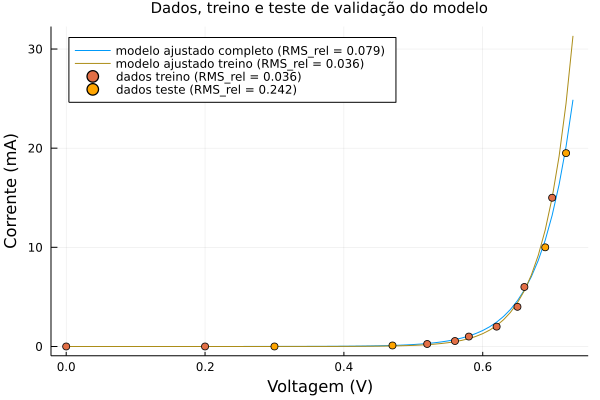

In [27]:
v = 0.0:0.01:0.73
plot(v, v -> model(v, β_fit), 
    label="modelo ajustado completo (RMS_rel = $(round(info.rms_rel, digits=3)))")
plot!(v, v -> model(v, β_fit_treino), color=5,
    label="modelo ajustado treino (RMS_rel = $(round(info_treino.rms_rel, digits=3)))")
scatter!(V_data[ind_treino], I_data[ind_treino], color=2, label="dados treino (RMS_rel = $(round(info_treino.rms_rel, digits=3)))")
scatter!(V_data[ind_teste], I_data[ind_teste], color=:orange,
    label="dados teste (RMS_rel = $(round(info_teste.rms_rel, digits=3)))",
    legend=:topleft, xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados, treino e teste de validação do modelo", titlefont=10)

### Comentário

* Observe que, apesar de visualmente a aproximação parecer boa, o erro quadrático médio relativo aumentou consideravelmente.

* Isso se deve mais ao baixo número de dados, aliado a uma qualidade não muito boa dos mesmos.

* Mais a seguir, faremos uma outra análise com dados melhores.

### Validação cruzada com dobras

In [28]:
seed = MersenneTwister(17003)
ind_shuffled = shuffle(seed, 1:length(V_data))
size_test = div(length(V_data), 4)
β₀ = [3e-5, 18.4]
fator = 0
for i in 1:size_test:length(V_data)-size_test+1
    ind_test = sort(ind_shuffled[i:(i + size_test - 1)])
    ind_treino = filter(n -> !(n in ind_test), 1:length(V_data))
    fit_treino = curve_fit(model, V_data[ind_treino], I_data[ind_treino], β₀)
    β_fit_treino = fit_treino.param
    info_treino = info_ajuste2(
            V_data[ind_treino], I_data[ind_treino], 
            model.(V_data[ind_treino], Ref(β_fit_treino)), length(β_fit_treino)
    )
    info_teste = info_ajuste2(
            V_data[ind_teste], I_data[ind_teste], 
            model.(V_data[ind_teste], Ref(β_fit_treino)), length(β_fit_treino)
    )
    
    fator += info_teste.rms_rel / info_treino.rms_rel
    println(ind_test)
    println(ind_treino)
    println(info_treino.rms_rel)
    println(info_teste.rms_rel)
    println()
end

fator /= div(length(V_data), size_test)
println(div(length(V_data), size_test))
println(fator)

[4, 9, 12]
[1, 2, 3, 5, 6, 7, 8, 10, 11, 13]
0.0314369077569385
0.013613878365324435

[1, 3, 11]
[2, 4, 5, 6, 7, 8, 9, 10, 12, 13]
0.07883004511365066
0.05580280718482376

[5, 6, 10]
[1, 2, 3, 4, 7, 8, 9, 11, 12, 13]
0.08005038515257462
0.04278941175707356

[2, 7, 13]
[1, 3, 4, 5, 6, 8, 9, 10, 11, 12]
0.07867579008515008
0.18972018412707695

4
1.0217225296547632


## Propagação de incertezas

* Matrizes de covariância e de correlação

In [29]:
covar = estimate_covar(fit)

2×2 Matrix{Float64}:
  1.84002e-11  -4.94724e-6
 -4.94724e-6    1.33131

In [30]:
estimate_covar(fit) ./ (stderror(fit) * stderror(fit)')

2×2 Matrix{Float64}:
  1.0       -0.999567
 -0.999567   1.0

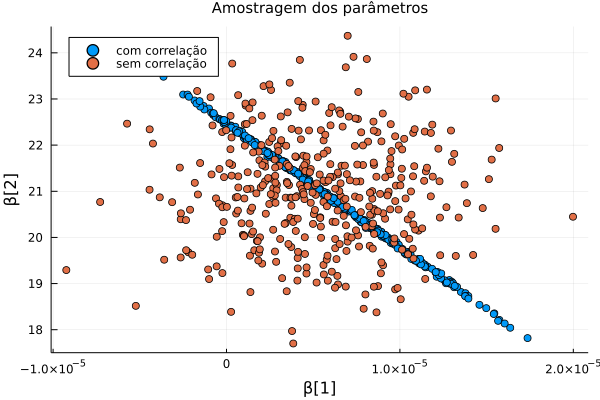

In [31]:
num_amostras = 400
plot(title="Amostragem dos parâmetros", titlefont=10, legend=false)
scatter!((r -> (r[1,:], r[2,:]))(rand(MersenneTwister(17011),MvNormal(β_fit,covar), num_amostras)), label="com correlação")
scatter!((rand(MersenneTwister(17012), Normal(β_fit[1],stderror(fit)[1]),num_amostras),
        rand(MersenneTwister(17013), Normal(β_fit[2],stderror(fit)[2]),num_amostras)), label="sem correlação",
        legend=:topleft, xlabel="β[1]", ylabel="β[2]")

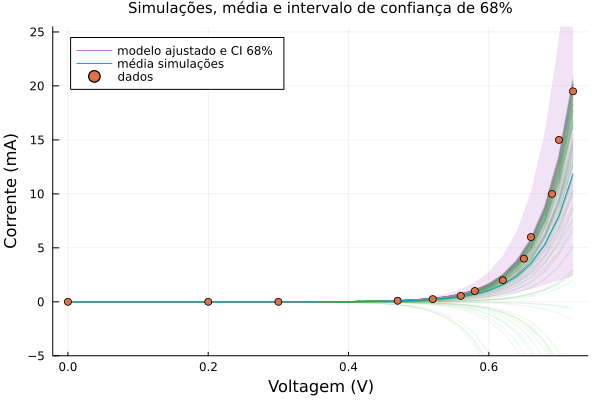

In [32]:
v = 0.0:0.02:0.73
num_amostras = 200
simulations = fill(0.0, length(v), num_amostras)
plot(title="Simulações, média e intervalo de confiança de 68%", titlefont=10)
for (n,β̃) in 
        enumerate(eachcol(rand(MersenneTwister(17011), MvNormal(β_fit,covar), num_amostras)))
    simulations[:,n] = model.(v,Ref(β̃))
    plot!(v, simulations[:,n], label=false, alpha=0.1 , legend=:bottomright,
        color=3)
end
plot!(v, model.(v, Ref(β_fit)), ribbon=sqrt.(var(simulations, dims=2)), fillalpha=0.2, 
    color=4, label="modelo ajustado e CI 68%")
plot!(v, mean(simulations, dims=2), color=6, label="média simulações")
scatter!(V_data, I_data, color=2, label="dados", legend=:topleft, ylim=(-5,25.5),
    xlabel="Voltagem (V)", ylabel="Corrente (mA)")

### Comentário

* Novamente, a baixa qualidade dos dados afetou consideravelmente a performance do método.

* Para outros sorteios (para o método de Monte-Carlo usado acima), o resultado é ainda pior.

* Observe as simulações onde a corrente assume valores negativos.

* Isso é consequência dos dados gerados para o parâmetro $\beta[1]$, que estão em um largo intervalo, entre $-1.0 \times 10^{-5}$ e $2.0 \times 10^{-5}$, que inclui valores negativos de $\beta[1]$.

* O parâmetro $\beta[2]$, por sua vez, aparece como um expoente no modelo e tem uma variação grande, levando, também, a uma grande sensibilidade do modelo.

## Outro experimento

* Vamos usar, agora, uma amostra maior de dados e obtidos com mais precisão.

* Novamente, dados de voltagem em Volts (V) e de corrente em miliamperes (mA).

* Fonte: ["EXPERIMENT 6:Observation of the V-I characteristic of a diode"](https://www.cmi.ac.in/~debangshu/lab1/diode.pdf) from [Debangshu Mukherjee (BS.c Physics,1st Year Chennai Mathematical Institute)](https://www.cmi.ac.in/~debangshu/).

* Observe que esses dados foram obtidos com outros componentes eletrônicos e em outras condições, portanto os parâmetros naturalmente podem ser diferentes do anterior.

* Esses dados foram obtidos em um laboratório científico, com um controle melhor, equipamento mais apropriado e, consequentemente, com um qualidade melhor dos dados.

### Dados

In [33]:
V_data_b = [0.283, 0.347, 0.370, 0.395, 0.425, 0.435, 0.445, 0.467, 0.485, 0.496, 0.503, 0.517, 0.525, 0.527, 0.538, 0.544, 0.555, 0.563, 0.573, 0.575, 0.585, 0.592, 0.598, 0.605, 0.618, 0.623, 0.630, 0.646, 0.653, 0.658, 0.665, 0.672, 0.677, 0.680]
I_data_b = [0.000, 0.001, 0.001, 0.005, 0.009, 0.012, 0.018, 0.047, 0.060, 0.082, 0.101, 0.145, 0.175, 0.181, 0.246, 0.306, 0.412, 0.509, 0.646, 0.693, 0.822, 0.979, 1.112, 1.335, 1.805, 2.007, 2.392, 3.4, 3.9, 4.3, 5.3, 6.7, 7.6, 8.0]
nothing

### Ajuste

In [34]:
β₀ = [3e-5, 18.4]
fit_b = curve_fit(model, V_data_b, I_data_b, β₀)
β_fit_b = fit_b.param

2-element Vector{Float64}:
  4.064157065428713e-7
 24.693695999413908

In [35]:
info_b = info_ajuste2(
            V_data_b, I_data_b, 
            model.(V_data_b, Ref(β_fit_b)), length(β_fit_b)
    )

(residuos = [0.0004401053841173197, 0.0011391071497600979, 0.002775096155652728, 0.001999353882187622, 0.005682541067886892, 0.0067952113536076525, 0.006059834058823852, -0.00557799730454514, 0.00460567495726634, 0.0027693812044732175  …  -0.08071133296974331, -0.056115019315654546, -0.07299315276306872, 0.042638572046209244, 0.1922465372285722, 0.3300264757970064, 0.20368832663611958, -0.15779440180489157, -0.19805470581076, -0.028888566793327186], rms = 0.09572597205098057, rms_rel = 0.03466656306076256, ss = 0.31155769865357386, ss_rel = 0.001201770594445827, r_sq = 0.9758130805223704, r_sq_aj = 0.9750572392886945, aic = -155.54606263943634, aicc = -159.1589658652428, bic = -145.4406205409717)

### Visualização

* Observe o $R^2$ ajustado bem mais próximo de 1, dessa vez.

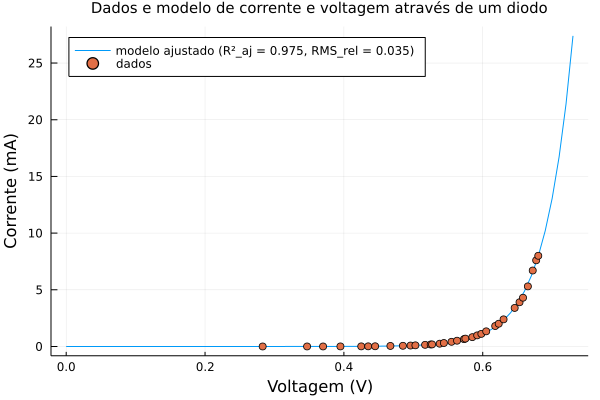

In [36]:
v = 0.0:0.01:0.73
plot(v, v -> model(v, β_fit_b), 
    label="modelo ajustado (R²_aj = $(round(info_b.r_sq_aj, digits=3)), RMS_rel = $(round(info_b.rms_rel, digits=3)))")
scatter!(V_data_b, I_data_b, color=2, label="dados", legend=:topleft,
    xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados e modelo de corrente e voltagem através de um diodo", titlefont=10)

### Validação

* O $R^2$ ajustado também se comporta bem melhor, dessa vez, nos permitindo confortavelmente validar o modelo.

In [37]:
seed_b = MersenneTwister(17201)
ind_treino_b = sort(shuffle(seed, 1:length(V_data_b))[begin:div(3*end,4)])
ind_teste_b = sort(shuffle(seed, 1:length(V_data_b))[div(3*end,4)+1:end])
println("Índices pra treino: $ind_treino_b")
println("Índices pra teste: $ind_teste_b")

Índices pra treino: [1, 2, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 34]
Índices pra teste: [5, 8, 12, 13, 14, 21, 28, 32, 34]


In [38]:
β₀ = [3e-5, 18.4]
fit_treino_b = curve_fit(model, V_data_b[ind_treino_b], I_data_b[ind_treino_b], β₀)
β_fit_treino_b = fit_treino_b.param

2-element Vector{Float64}:
  4.219582861854398e-7
 24.632454242156054

In [39]:
info_treino_b = info_ajuste2(
            V_data_b[ind_treino_b], I_data_b[ind_treino_b], 
            model.(V_data_b[ind_treino_b], Ref(β_fit_treino_b)), length(β_fit_treino_b)
    )

(residuos = [0.0004490779872725287, 0.001174205845741756, 0.00585238630784817, 0.00630836871531, -0.0052064534787602396, 0.0033779836759232212, 0.00044494399442196464, -0.0017814478537871714, -0.0005859690160973652, 0.0022217166554451273  …  -0.05737839069875905, -0.058784505383216556, -0.0812587031280001, -0.05733141691369936, -0.07543238307056432, 0.0356493321596103, 0.18218808932696762, 0.3172321519581871, -0.18146400358243397, -0.061618161482075884], rms = 0.09214754533061789, rms_rel = 0.03529594954649154, ss = 0.21227925276145695, ss_rel = 0.0012458040543884762, r_sq = 0.9652383275581939, r_sq_aj = 0.9637269504955067, aic = -115.21821164894526, aicc = -118.67275710349071, bic = -106.34270834947246)

In [40]:
info_teste_b = info_ajuste2(
            V_data_b[ind_teste_b], I_data_b[ind_teste_b], 
            model.(V_data_b[ind_teste_b], Ref(β_fit_treino_b)), length(β_fit_treino_b)
    )

(residuos = [0.00585238630784817, -0.0052064534787602396, -0.0017814478537871714, -0.0005859690160973652, 0.0022217166554451273, -0.05737839069875905, 0.0356493321596103, -0.18146400358243397, -0.061618161482075884], rms = 0.06778966452488322, rms_rel = 0.018471886062552074, ss = 0.0413589475475659, ss_rel = 0.00034121057470790555, r_sq = 0.8654532205419352, r_sq_aj = 0.846232252047926, aic = -44.444219653255686, aicc = -46.444219653255686, bic = -39.655321343910806)

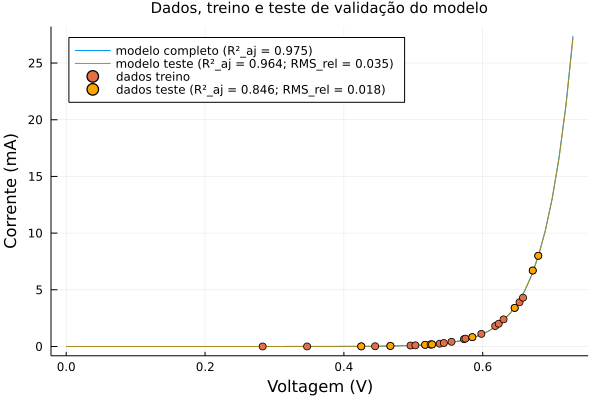

In [41]:
v = 0.0:0.01:0.73
plot(v, v -> model(v, β_fit_b), 
    label="modelo completo (R²_aj = $(round(info_b.r_sq_aj, digits=3)))")
plot!(v, v -> model(v, β_fit_treino_b), color=5,
    label="modelo teste (R²_aj = $(round(info_treino_b.r_sq_aj, digits=3)); RMS_rel = $(round(info_treino_b.rms_rel, digits=3)))")
scatter!(V_data_b[ind_treino_b], I_data_b[ind_treino_b], color=2, label="dados treino")
scatter!(V_data_b[ind_teste_b], I_data_b[ind_teste_b], color=:orange,
    label="dados teste (R²_aj = $(round(info_teste_b.r_sq_aj, digits=3)); RMS_rel = $(round(info_teste_b.rms_rel, digits=3)))",
    legend=:topleft, xlabel="Voltagem (V)", ylabel="Corrente (mA)",
    title="Dados, treino e teste de validação do modelo", titlefont=10)

### Propagação de incertezas

* Da mesma forma, com esses dados de maior qualidade, os intervalos de confiança aparecem bem mais "justos".

In [42]:
covar_b = estimate_covar(fit_b)

2×2 Matrix{Float64}:
  8.56058e-15  -3.15705e-8
 -3.15705e-8    0.116513

In [43]:
estimate_covar(fit_b) ./ (stderror(fit_b) * stderror(fit_b)')

2×2 Matrix{Float64}:
  1.0       -0.999637
 -0.999637   1.0

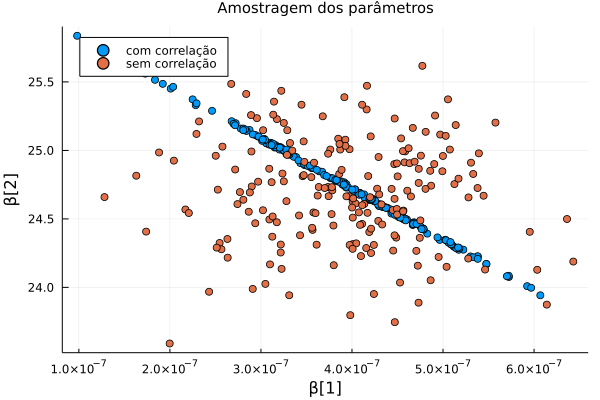

In [44]:
num_amostras = 200
plot(title="Amostragem dos parâmetros", titlefont=10, legend=false)
scatter!((r -> (r[1,:], r[2,:]))(rand(MersenneTwister(17211),MvNormal(β_fit_b,covar_b), num_amostras)), label="com correlação")
scatter!((rand(MersenneTwister(17212), Normal(β_fit_b[1],stderror(fit_b)[1]),num_amostras),
        rand(MersenneTwister(17213), Normal(β_fit_b[2],stderror(fit_b)[2]),num_amostras)), label="sem correlação",
        legend=:topleft, xlabel="β[1]", ylabel="β[2]")

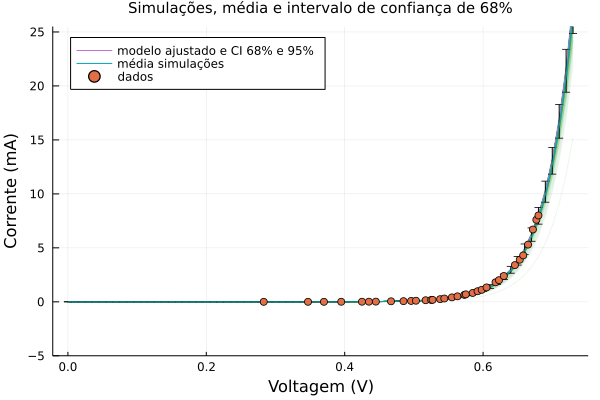

In [45]:
v = 0.0:0.01:0.73
num_amostras = 200
simulations_b = fill(0.0, length(v), num_amostras)
plot(title="Simulações, média e intervalo de confiança de 68%", titlefont=10)
for (n,β̃) in 
        enumerate(eachcol(rand(MersenneTwister(17211), MvNormal(β_fit_b,covar_b), num_amostras)))
    simulations_b[:,n] = model.(v, Ref(β̃))
    plot!(v, simulations_b[:,n], label=false, alpha=0.1 , legend=:bottomright,
        color=3)
end
plot!(v, model.(v, Ref(β_fit_b)), ribbon=sqrt.(var(simulations_b, dims=2)), fillalpha=0.2,
    yerror=2*sqrt.(var(simulations_b, dims=2)), color=4, label="modelo ajustado e CI 68% e 95%")
plot!(v, mean(simulations_b, dims=2), color=6, label="média simulações")
scatter!(V_data_b, I_data_b, color=2, label="dados", legend=:topleft, ylim=(-5,25.5),
    xlabel="Voltagem (V)", ylabel="Corrente (mA)")

### Comentários

* Observe como o modelo apresenta um grau de confiança muito melhor.

* A forma de se analisar a propagação de erros é a mesma.

* O que é melhorou foi a qualidade do ajuste dos dados.

* Observe, em particular, que o parâmetro $\beta[1]$ foi gerado com um erro padrão muito menor, com as amostras desse parâmetro ficando restritas a um intervalo muito menor, entre $1.0 \times 10^{-7}$ e $6.0 \times 10^{-7}$. Não tendo valores negativos, não há casos de corrente negativa.

* O parâmetro $\beta[2]$, por sua vez, implica em extrema sensibilidade do modelo, por ser um expoente, mas ele também ficou restrito a um intervalo relativamente pequeno.

## Exercício

1. Faça a validação do modelo de três parâmetros utilizando a segunda amostra de dados.

1. Faça a análise de propagação de incertezas do modelo de três parâmetros e utilizando a segunda amostra de dados.

1. Faça a validação cruzada do modelo polinomial de grau quatro.

1. Um outro modelo de três parâmetros aparece em [E. Cataldo, A. Di Lieto F. Maccarrone, G. Paffuti, Measurements and analysis of current-voltage characteristic of a pn diode for an undergraduate physics laboratory](https://arxiv.org/abs/1608.05638v1), na equação (4), que podemos escrever como
$$ I = GV + I_\mathrm{S} \left( e^{\displaystyle B(V-R_\mathrm{S}(I - GV)} - 1 \right).
$$
O parâmetro $G$ é relativamente baixo, de modo que, para correntes maiores, ele pode ser desprezado e o modelo, reduzido a
$$ I = I_\mathrm{S} \left( e^{\displaystyle B(V-R_\mathrm{S}I)} - 1 \right).
$$
Conforme feito em (7), no artigo, é mais fácil tratar essa aproximação na forma de voltagem em função da corrente, reescrevendo-o como
$$ V = \frac{1}{B}\ln\left( \frac{I}{I_\mathrm{S}} + 1 \right) + R_\mathrm{S} I.
$$
Faça o ajuste dos parâmetros desse modelo ao segundo conjunto de dados.

<!--NAVIGATOR-->

---
[<- 8. Eletrônica](08.00-Eletronica.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [9. Reações químicas e bioquímicas ->](09.00-Reacoes_quimicas.ipynb)